## ESAT K Estimation Workflow 2 - Bootstrap Evaluation

This notebook implements a bootstrap approach to using solution profile variabilty to estimate optimal number of factors in a dataset.

#### Code Imports

In [1]:
import time
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.error.bootstrap import Bootstrap
from esat_eval.simulator import Simulator
from esat.estimator import FactorEstimator

In [2]:
# Synethic dataset parameter value ranges
syn_factors_min = 3
syn_factors_max = 8

syn_features_min = 15
syn_features_max = 45

syn_samples_min = 200
syn_samples_max = 1000

outliers = True
outliers_p_min = 0.05
outliers_p_max = 0.1
outliers_mag_min = 1.1
outliers_mag_max = 2

noise_mean_min = 0.05
noise_mean_max = 0.15
noise_scale = 0.01

uncertainty_mean_min = 0.05
uncertainty_mean_max = 0.15
uncertainty_scale = 0.01

contr_curve_min_range = [0.0, 1.0]
contr_curve_max_range = [2.0, 5.0]
contr_curve_scale_range = [0.1, 0.5]

random_seed = 337
k_coef = 0.75

In [3]:
rng = np.random.default_rng(seed=random_seed)

In [4]:
# Initialize the simulator with the above parameters
def generate_synthetic_data(true_factor):
    n_features = rng.integers(low=syn_features_min, high=syn_features_max, size=1)[0]
    n_samples = rng.integers(low=syn_samples_min, high=syn_samples_max, size=1)[0]
    i_outlier_p = round(rng.uniform(low=outliers_p_min, high=outliers_p_max, size=1)[0], 2)
    i_outlier_mag = round(rng.uniform(low=outliers_mag_min, high=outliers_mag_max, size=1)[0], 2)
    contribution_max = round(rng.uniform(low=1.0, high=10.0, size=1)[0], 2)
    print(f"True Factors: {true_factor}, Features: {n_features}, Samples: {n_samples}, Outliers %: {i_outlier_p}, Outliers Magnitude: {i_outlier_mag}, Contribution Max: {contribution_max}")
    simulator = Simulator(seed=rng.integers(low=0, high=10, size=1)[0],
                          factors_n=true_factor,
                          features_n=n_features,
                          samples_n=n_samples,
                          outliers=outliers,
                          outlier_p=i_outlier_p,
                          outlier_mag=i_outlier_mag,
                          contribution_max=contribution_max,
                          noise_mean_min=noise_mean_min,
                          noise_mean_max=noise_mean_max,
                          noise_scale=noise_scale,
                          uncertainty_mean_min=uncertainty_mean_min,
                          uncertainty_mean_max=uncertainty_mean_max,
                          uncertainty_scale=uncertainty_scale,
                          verbose=False
                         )
    curved_factors_count = rng.integers(low=0, high=true_factor, size=1)[0]
    curved_factor_list = rng.choice(list(range(true_factor)), size=curved_factors_count, replace=False)
    for c_i in curved_factor_list:
        # parameters not used by the curve type are ignored
        i_curve_type = rng.choice(['uniform', 'decreasing', 'increasing', 'logistic', 'periodic'], size=1)[0]
        i_curve_min = rng.uniform(low=contr_curve_min_range[0], high=contr_curve_min_range[1], size=1)[0]
        i_curve_max = rng.uniform(low=contr_curve_max_range[0], high=contr_curve_max_range[1], size=1)[0]
        i_curve_scale = rng.uniform(low=contr_curve_scale_range[0], high=contr_curve_scale_range[1], size=1)[0]
        i_curve_frequency = rng.uniform(low=0.1, high=0.9, size=1)[0]
        
        # To keep all as uniform comment out the line below
        # simulator.update_contribution(factor_i=c_i, curve_type=i_curve_type, scale=i_curve_scale, frequency=i_curve_frequency, minimum=i_curve_min, maximum=i_curve_max)
    
    syn_input_df, syn_uncertainty_df = simulator.get_data()
    data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
    data_handler.metrics
    V, U = data_handler.get_data()
    return V, U


def run_bs(k, bV, bU, bseed, bs_instances: int = 20, block_size: int = 4, threshold: float = 0.9):
    # Runs a bootstrap instance
    # Steps:
    # 1. Generate base model with a specified number of factors
    # 2. Generate bs_instances number of bootstrap datasets
    # 3. For each bootstrap dataset, use the base model H profiles for initialization. Run to convergence.
    # 4. On each converged bs model, calculate the average correlation of the mapped profiles.
    # 5. Reported metrics for each bootstrap run. K, % mapped profiles, mean mapped correlation, mean overall correlation, mean QTrue

    # Base Model, step 1
    base_sa = SA(V=bV, U=bU, factors=k, seed=bseed, verbose=False)
    base_sa.initialize()
    base_sa.train(max_iter=20000, converge_delta=0.1, converge_n=10)

    # BS instance, steps 2-3
    bs = Bootstrap(sa=base_sa, model_selected=-1, bootstrap_n=bs_instances, block_size=block_size, threshold=threshold, seed=bseed, parallel=True)
    bs.run()

    # Evaluate correlations, step 4
    # for each bs result get the mapping correlations bs.bs_results[1]['mapping']
    compare_count = 0
    mapped = 0
    mapped_correlations = []
    notmapped_correlations = []
    for i, i_result in bs.bs_results.items():
        i_mapping = i_result["mapping"]
        for j, j_factor in i_mapping.items():
            compare_count += 1
            if j_factor["mapped"]:
                mapped_correlations.append(j_factor["r2"])
                mapped += 1
            else:
                notmapped_correlations.append(j_factor["r2"])
    # return results, step 5
    mapped_correlations_mean = 0.0 if len(mapped_correlations) == 0 else round(np.mean(mapped_correlations), 4)
    bs_results = {
        "k": k,
        "seed": bseed,
        "% mapped": round((mapped/compare_count) * 100, 2),
        "mean mapped r2":mapped_correlations_mean,
        "mean r2": round((np.sum(mapped_correlations)+np.sum(notmapped_correlations))/(len(mapped_correlations)+len(notmapped_correlations)), 4),
        "mean QRobust": round(np.mean(bs.q_results), 4)
    }
    return bs_results

def run_bs_batch(k, n_batches, bV, bU, bseed, bs_instances: int = 20, block_size: int = 4, threshold: float = 0.9, ):
    results = {
        "k": k,
        "seed": bseed,
        "% mapped": [],
        "mean mapped r2": [],
        "mean r2": [],
        "mean QRobust": []
    }
    for i in range(n_batches):
        i_seed = rng.integers(low=0, high=1e10, endpoint=True, size=1)[0]
        i_result = run_bs(k=i_factor, bV=bV, bU=bU, bseed=i_seed, bs_instances=bs_instances)
        results["% mapped"].append(i_result["% mapped"])
        results["mean mapped r2"].append(i_result["mean mapped r2"])
        results["mean r2"].append(i_result["mean r2"])
        results["mean QRobust"].append(i_result["mean QRobust"])
    results["% mapped"] = round(np.mean(results["% mapped"]), 4)
    results["mean mapped r2"] = round(np.mean(results["mean mapped r2"]), 4) if len(results["mean mapped r2"]) > 0 else 0.0
    results["mean r2"] = round(np.mean(results["mean r2"]), 4)
    results["mean QRobust"] = round(np.mean(results["mean QRobust"]), 4)
    return results
    

In [55]:
%%time
true_k = 10
i_V, i_U = generate_synthetic_data(true_factor=true_k)

n_batches = 5
bs_instances = 20
min_factors = 2
max_factors = 12

results_list0 = []
for i_factor in range(min_factors, max_factors+1):
    t0 = time.time()
    bseed = rng.integers(low=0, high=1e10, endpoint=True, size=1)[0]
    i_results = run_bs_batch(k=i_factor, n_batches=n_batches, bV=i_V, bU=i_U, bseed=bseed, bs_instances=bs_instances)
    results_list0.append(i_results)
    t1 = time.time()
    print(f"Results: {i_results}, Runtime {round(t1-t0, 2)} sec(s)")
# results_list0

True Factors: 10, Features: 43, Samples: 305, Outliers %: 0.06, Outliers Magnitude: 1.22, Contribution Max: 4.71
Results: {'k': 2, 'seed': 7100509008, '% mapped': 67.5, 'mean mapped r2': 0.9664, 'mean r2': 0.9297, 'mean QRobust': 131600.1607}, Runtime 43.44 sec(s)
Results: {'k': 3, 'seed': 4883276074, '% mapped': 46.334, 'mean mapped r2': 0.9513, 'mean r2': 0.8428, 'mean QRobust': 103201.2767}, Runtime 63.11 sec(s)
Results: {'k': 4, 'seed': 1974513018, '% mapped': 71.75, 'mean mapped r2': 0.9555, 'mean r2': 0.9089, 'mean QRobust': 83146.4394}, Runtime 83.24 sec(s)
Results: {'k': 5, 'seed': 5415386736, '% mapped': 62.4, 'mean mapped r2': 0.9582, 'mean r2': 0.8882, 'mean QRobust': 66657.0444}, Runtime 106.35 sec(s)
Results: {'k': 6, 'seed': 1287725022, '% mapped': 67.334, 'mean mapped r2': 0.9568, 'mean r2': 0.889, 'mean QRobust': 52892.1083}, Runtime 119.71 sec(s)
Results: {'k': 7, 'seed': 7487232740, '% mapped': 78.714, 'mean mapped r2': 0.9647, 'mean r2': 0.9136, 'mean QRobust': 41136

True K: 10, Best Mapped R2: factor=10, R2=0.9799, Best R2: factor=10, R2=0.9609


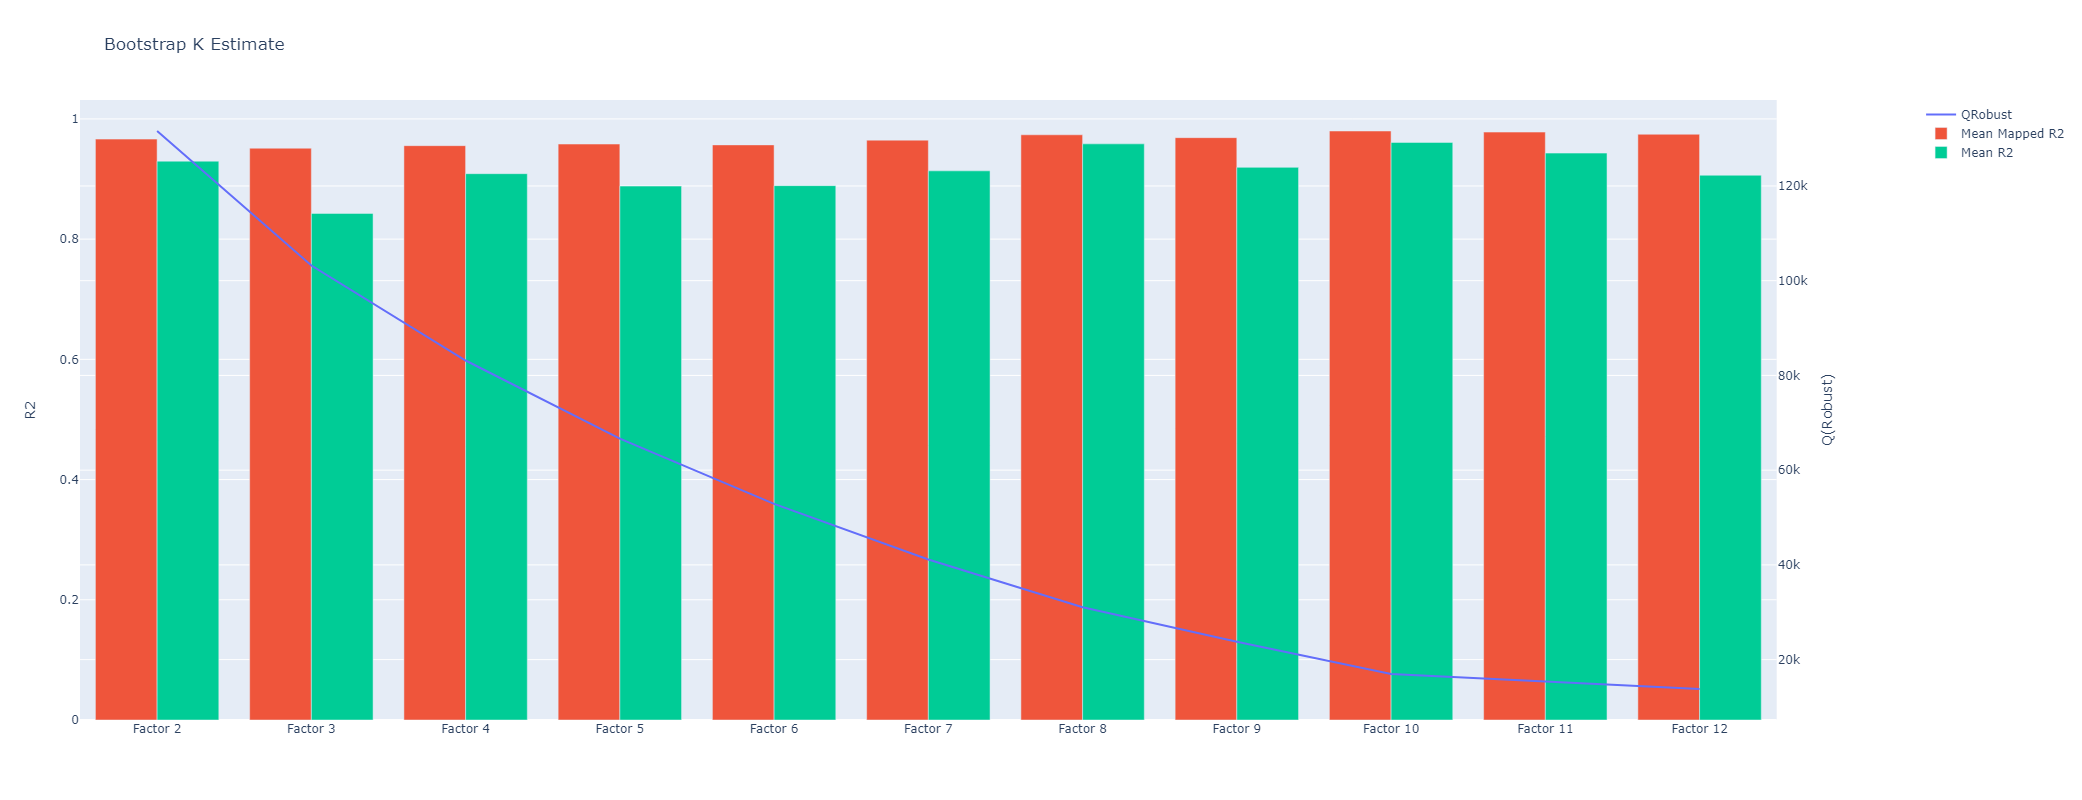

In [56]:
factor_labels = [f"Factor {i}" for i in range(min_factors, max_factors+1)]
q_robust = []
mean_mapped_r2 = []
mean_r2 = []
mapped_p = []

best_r2_i = -1
best_r2 = 0
best_mr2_i = -1
best_mr2 = 0

for i, i_r in enumerate(results_list0):
    mr2 = i_r["mean mapped r2"]
    r2 = i_r["mean r2"]
    if best_r2 < r2:
        best_r2 = r2
        best_r2_i = i + min_factors
    if best_mr2 < mr2:
        best_mr2 = mr2
        best_mr2_i = i + min_factors
    q_robust.append(i_r["mean QRobust"])
    mean_mapped_r2.append(mr2)
    mean_r2.append(r2)
    mapped_p.append(i_r["% mapped"])

print(f"True K: {true_k}, Best Mapped R2: factor={best_mr2_i}, R2={best_mr2}, Best R2: factor={best_r2_i}, R2={best_r2}")

results_fig = make_subplots(specs=[[{"secondary_y": True}]])
results_fig.add_trace(go.Scatter(name="QRobust", x=factor_labels, y=q_robust, mode="lines"), secondary_y=True)
results_fig.add_trace(go.Bar(name="Mean Mapped R2", x=factor_labels, y=mean_mapped_r2), secondary_y=False)
results_fig.add_trace(go.Bar(name="Mean R2", x=factor_labels, y=mean_r2), secondary_y=False)

results_fig.update_layout(barmode='group', width=1200, height=800, title_text="Bootstrap K Estimate", hovermode='x unified')
results_fig.update_yaxes(title="Q(Robust)", secondary_y=True)
results_fig.update_yaxes(title="R2", secondary_y=False)
results_fig.show()

In [57]:
bs_scores = []
bs_r_scores = []
for i, i_r in enumerate(results_list0):
    mr2 = i_r["mean mapped r2"]
    r2 = i_r["mean r2"]
    p_m = i_r["% mapped"]
    bs_scores.append(p_m * mr2)
    bs_r_scores.append(p_m * r2)
bs_df = pd.DataFrame(data={"BS Score": bs_scores, "All Score": bs_r_scores, "Factors": factor_labels})
print(f"Estimated K - True K: {true_k}, Mapped Score: {bs_df.iloc[bs_df['BS Score'].idxmax()]['Factors']}, R2 Score: {bs_df.iloc[bs_df['All Score'].idxmax()]['Factors']}")
bs_df

Estimated K - True K: 10, Mapped Score: Factor 8, R2 Score: Factor 8


,BS Score,All Score,Factors
0,65.232000,62.754750,Factor 2
1,44.077534,39.050295,Factor 3
2,68.557125,65.213575,Factor 4
3,59.791680,55.423680,Factor 5
4,64.425171,59.859926,Factor 6
5,75.935396,71.913110,Factor 7
6,89.327800,87.942375,Factor 8
7,74.597600,70.793800,Factor 9
8,88.288990,86.577090,Factor 10
9,81.894357,78.963877,Factor 11


In [58]:
%%time
# Sampling parameters
n_batches = 5
bs_instances = 10
min_factors = 2
max_factors = 10
all_results = []

# for j in range(100):
#     t0 = time.time()
#     true_k = rng.integers(low=syn_factors_min, high=syn_factors_max, endpoint=True, size=1)[0]
#     i_V, i_U = generate_synthetic_data(true_factor=true_k)
    
#     results_list = []
#     predicted_k = -1
#     best_r2 = 0
#     for i_factor in range(min_factors, max_factors+1):
#         bseed = rng.integers(low=0, high=1e10, endpoint=True, size=1)[0]
#         i_results = run_bs_batch(k=i_factor, n_batches=n_batches, bV=i_V, bU=i_U, bseed=bseed, bs_instances=bs_instances)
#         if i_results['mean r2'] > best_r2:
#             best_r2 = i_results['mean r2']
#             predicted_k = i_results['k']
#         results_list.append(i_results)
#     t1 = time.time()
#     print(f"Predicted K: {predicted_k}, R2: {best_r2}. Runtime: {round(t1-t0, 4)} sec")
#     all_results.append(results_list)

CPU times: total: 0 ns
Wall time: 0 ns
